In [1]:
import sys
sys.path.append("./tools")

In [2]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.visualization import plot_bloch_multivector, plot_histogram

simulator = Aer.get_backend('qasm_simulator')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
palette = {
    'unitary': '#FF9966', 'vqc': '#66CC99', 
}

In [5]:
%matplotlib inline

## Tool Modules

In [6]:
from unitary import *
from VQC import *

from dataSL import *#

## Prepare Circuits

### - input circuit

In [7]:
def initCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    senders = circuit.qubits[0:n]
    receivers = circuit.qubits[n:]
    
    for sender, receiver in zip(senders, receivers):
        circuit.h(sender)
        circuit.cx(sender, receiver)
        
    return senders, receivers, circuit

In [9]:
def operate(circuit, target, bits):
    """
        => Z^(b_1) * X^(b_2)
    """
    if bits[0] == '1':
        circuit.z(target)
    if bits[1] == '1':
        circuit.x(target)

    return circuit

def getCircuit(n, classical_bits):
    bits_str = ''.join(classical_bits)
    """
        getCircuit(circuit, ["01", "10", "00"])
            => X(A1), Z(A2), I(A3)
    """
    senders, receivers, circuit = initCircuit(n)
    circuit_copy = circuit.copy()
    
    circuit_copy.barrier(senders)
    for i, sender in enumerate(senders):
        operate(circuit_copy, sender, classical_bits[i])

    return circuit_copy

### - target circuit

In [10]:
def getTargetCircuit(strategy, n, p, pos):
    circuit = QuantumCircuit(2 * n, 2 * n)
    
    if strategy == 'vqc':
        circuit = getVQCCircuit(circuit, n, p, pos)
    elif strategy == 'unitary':
        unitary = buildU(n, p)
        circuit.append(unitary, pos)
        
    return circuit

### - Output Circuits

In [12]:
def getMeasureCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    
    for i in range(n):
        circuit.cx(i, i + n)
        circuit.h(i)
    
    return circuit

### - Full Circuit

In [13]:
def getFullCircuit(strategy, n, bits, p):
    inputCircuit = getCircuit(n, bits)
    inputCircuit.barrier()
    
    targetCircuit = getTargetCircuit(strategy, n, p, [0, 1])
    targetCircuit.barrier()
    
    outputCircuit = getMeasureCircuit(n)
    
    return inputCircuit.compose(targetCircuit).compose(outputCircuit)

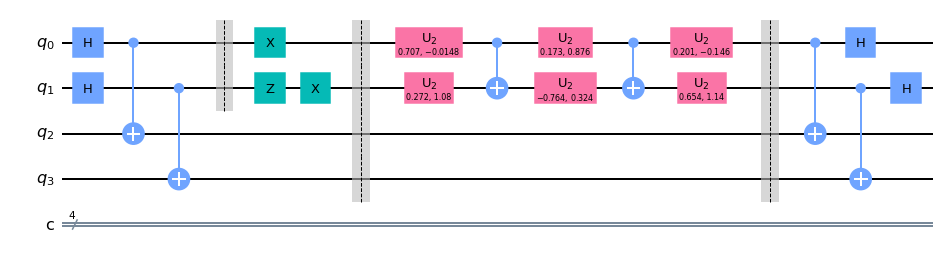

In [14]:
qc = getFullCircuit('vqc', 2, ['01', '11'], loadParams('sdc2', 'vqc', 2))
qc.draw(output='mpl')

In [18]:
len(loadParams('sdc3', 'vqc', 4))

18

In [19]:
len(loadParams('sdc3', 'unitary', 4))

64

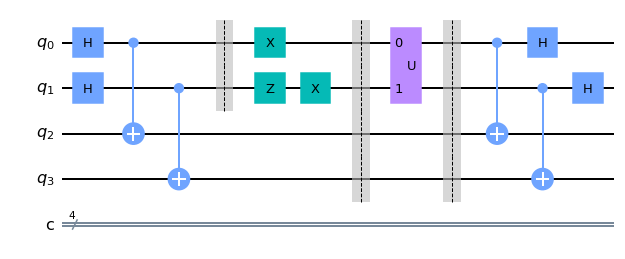

In [15]:
qc = getFullCircuit('unitary', 2, ['01', '11'], loadParams('sdc2', 'unitary', 4))
qc.draw(output='mpl')

## Validate

### - infos

In [20]:
allInfos = []
classical_bits = ["00", "01", "10", "11"]
for comb in combs[2]:
    allInfos.append(list(map( lambda x: classical_bits[int(x)] , list(comb))))

print(allInfos)
print(len(allInfos))

[['00', '00'], ['00', '01'], ['00', '10'], ['00', '11'], ['01', '00'], ['01', '01'], ['01', '10'], ['01', '11'], ['10', '00'], ['10', '01'], ['10', '10'], ['10', '11'], ['11', '00'], ['11', '01'], ['11', '10'], ['11', '11']]
16


In [104]:
infos_example = ["11", "01"]

### - statistic

In [22]:
def statisticCount(counts):
    dict1 = {'00': 0, '01': 0, '10': 0, '11': 0}
    dict2 = {'00': 0, '01': 0, '10': 0, '11': 0}

    for key in counts:
        # dict[key[:2]]
        dict1[ key[:2] ] += counts[key]
        dict2[ key[2:4] ] += counts[key]

    stds = np.array([
        np.std(list(dict1.values())),
        np.std(list(dict2.values())),
    ])
    
    print(f'1: {dict1}, std: {stds[0]}')
    print(f'2: {dict2}, std: {stds[1]}')
    
    return stds

In [23]:
def stat(circuit, shots=1000):
    circuit = circuit.copy()
    circuit.measure([0, 2, 1, 3], [3, 2, 1, 0])
    
    job = execute(circuit, simulator, shots = shots)
    results = job.result()
    counts = results.get_counts(circuit)
    
    print(counts)
    print()
    statisticCount(counts)

In [29]:
def statAll(strategy, circuitFactory, infos, *, shots=1000, params=None):
    stds = np.array([0.0, 0.0])
    
    for i, info in enumerate(infos):
        print(f'No. {i + 1}: info: {info}\n')
        
        if not isinstance(params, type(None)):
            circuit = circuitFactory(strategy, 2, info, params)
        else:
            circuit = circuitFactory(strategy, 2, info)
        circuit.measure([0, 2, 1, 3], [3, 2, 1, 0])

        job = execute(circuit, simulator, shots = shots)
        results = job.result()
        counts = results.get_counts(circuit)
        
        stds += statisticCount(counts)
        print()
    
    print('-' * 64)
    print('Average: ', stds / 16)

In [30]:
def getCounts(circuit, shots=1000):
    circuit = circuit.copy()
    circuit.measure([0, 2, 1, 3], [3, 2, 1, 0])
    
    job = execute(circuit, simulator, shots = shots)
    results = job.result()
    counts = results.get_counts(circuit)
    
    return counts

## Test: Unitary

In [132]:
best_unitary_params = loadParams('sdc2', 'unitary', 9)

In [88]:
statAll('unitary', getFullCircuit, allInfos, shots=10000, params=best_unitary_params)

No. 1: info: ['00', '00']

1: {'00': 2576, '01': 2312, '10': 2464, '11': 2648}, std: 126.80693987317886
2: {'00': 2500, '01': 2469, '10': 2472, '11': 2559}, std: 36.145539143855636

No. 2: info: ['00', '01']

1: {'00': 2468, '01': 2319, '10': 2571, '11': 2642}, std: 121.43928524163834
2: {'00': 2532, '01': 2478, '10': 2522, '11': 2468}, std: 27.459060435491963

No. 3: info: ['00', '10']

1: {'00': 2482, '01': 2269, '10': 2565, '11': 2684}, std: 151.4645172969564
2: {'00': 2414, '01': 2610, '10': 2437, '11': 2539}, std: 79.03480246068817

No. 4: info: ['00', '11']

1: {'00': 2536, '01': 2325, '10': 2488, '11': 2651}, std: 117.11746240420341
2: {'00': 2499, '01': 2476, '10': 2518, '11': 2507}, std: 15.411035007422441

No. 5: info: ['01', '00']

1: {'00': 2205, '01': 2510, '10': 2680, '11': 2605}, std: 180.65851765139666
2: {'00': 2529, '01': 2449, '10': 2475, '11': 2547}, std: 39.61060464067672

No. 6: info: ['01', '01']

1: {'00': 2282, '01': 2543, '10': 2627, '11': 2548}, std: 130.1979

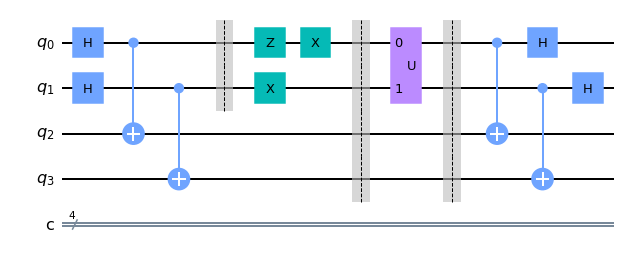

In [133]:
unitary_circuit = getFullCircuit('unitary', 2, infos_example, best_unitary_params)
unitary_circuit.draw(output='mpl')

In [134]:
stat(unitary_circuit, shots=10000)

{'0010': 707, '1011': 600, '1000': 597, '0111': 615, '0100': 608, '0011': 665, '1100': 686, '1110': 635, '0001': 609, '0101': 626, '1101': 640, '1111': 603, '0000': 626, '0110': 664, '1010': 553, '1001': 566}

1: {'00': 2607, '01': 2513, '10': 2316, '11': 2564}, std: 111.32160616879366
2: {'00': 2517, '01': 2441, '10': 2559, '11': 2483}, std: 43.41658669218482


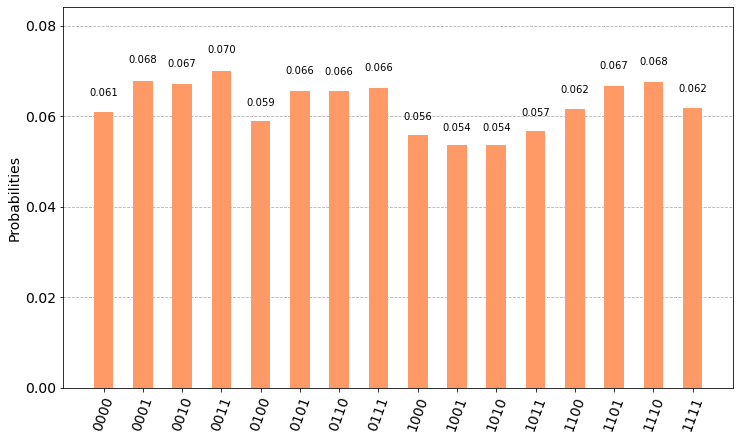

In [138]:
plot_histogram(getCounts(unitary_circuit, shots=10000), figsize=(12,7), color=palette['unitary'])

## Test: VQC

In [139]:
best_vqc_params = loadParams('sdc2', 'vqc', 8)

In [95]:
statAll('vqc', getFullCircuit, allInfos, shots=10000, params=best_vqc_params)

No. 1: info: ['00', '00']

1: {'00': 2457, '01': 2447, '10': 2527, '11': 2569}, std: 50.368641037852115
2: {'00': 2428, '01': 2458, '10': 2590, '11': 2524}, std: 62.49799996799898

No. 2: info: ['00', '01']

1: {'00': 2459, '01': 2536, '10': 2579, '11': 2426}, std: 60.609405210742665
2: {'00': 2485, '01': 2570, '10': 2549, '11': 2396}, std: 67.71632004177427

No. 3: info: ['00', '10']

1: {'00': 2587, '01': 2507, '10': 2532, '11': 2374}, std: 78.29112337934615
2: {'00': 2448, '01': 2541, '10': 2529, '11': 2482}, std: 37.24916106437835

No. 4: info: ['00', '11']

1: {'00': 2472, '01': 2500, '10': 2477, '11': 2551}, std: 31.280984639234106
2: {'00': 2499, '01': 2495, '10': 2540, '11': 2466}, std: 26.372333988481188

No. 5: info: ['01', '00']

1: {'00': 2561, '01': 2507, '10': 2406, '11': 2526}, std: 57.623779813545724
2: {'00': 2491, '01': 2520, '10': 2519, '11': 2470}, std: 20.868636754709208

No. 6: info: ['01', '01']

1: {'00': 2497, '01': 2435, '10': 2520, '11': 2548}, std: 41.647328

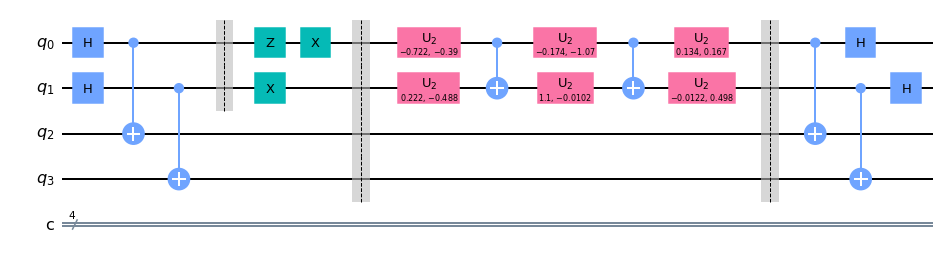

In [140]:
vqc_circuit = getFullCircuit('vqc', 2, infos_example, best_vqc_params)
vqc_circuit.draw(output='mpl')

In [143]:
stat(vqc_circuit, shots=10000)

{'0111': 673, '0110': 621, '1011': 691, '0010': 661, '1100': 592, '1001': 545, '0101': 542, '0100': 698, '1111': 599, '0001': 672, '1000': 649, '1110': 648, '1010': 554, '0000': 563, '0011': 566, '1101': 726}

1: {'00': 2462, '01': 2534, '10': 2439, '11': 2565}, std: 51.34685968976097
2: {'00': 2502, '01': 2485, '10': 2484, '11': 2529}, std: 18.207141456033124


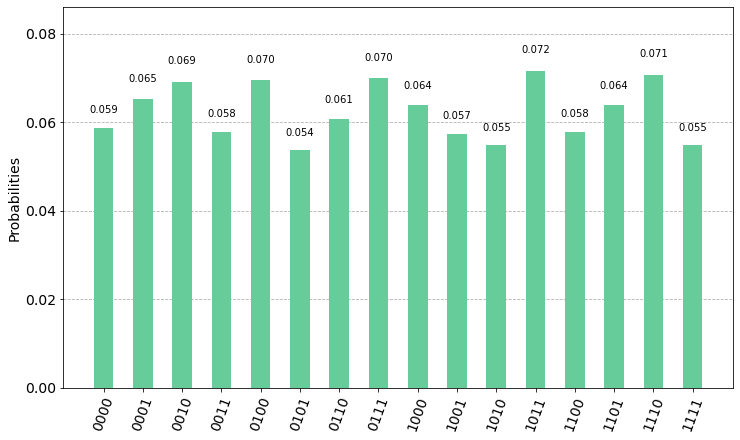

In [148]:
plot_histogram(getCounts(vqc_circuit, shots=10000), figsize=(12,7), color=palette['vqc'])